# Assignment 2

### Name : Sarthak Johnson Prasad

### Roll No. : 18CS10049

In [1]:
# Required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import math
import statistics

plt.style.use('fivethirtyeight')

# We read the data frame
df=pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')



### Checking our data

In [2]:
# For getting the starting rows
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
# For getting dimensions of our data
df.shape

(1825, 7)

In [4]:
# For getting unique values
len(df['Date'].unique())

1825

So we have every unique data Stock opening and closing prices. So no duplicates or inconsistent values (Good for us!)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


No null values!

But Date has been set to **Object** type, we need to change it to datetime.

In [6]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
# To change Date from Object to datetime
df.Date=pd.to_datetime(df['Date'])

In [8]:
# We set Date as our index for plots
df.set_index('Date',inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


<AxesSubplot:xlabel='Date'>

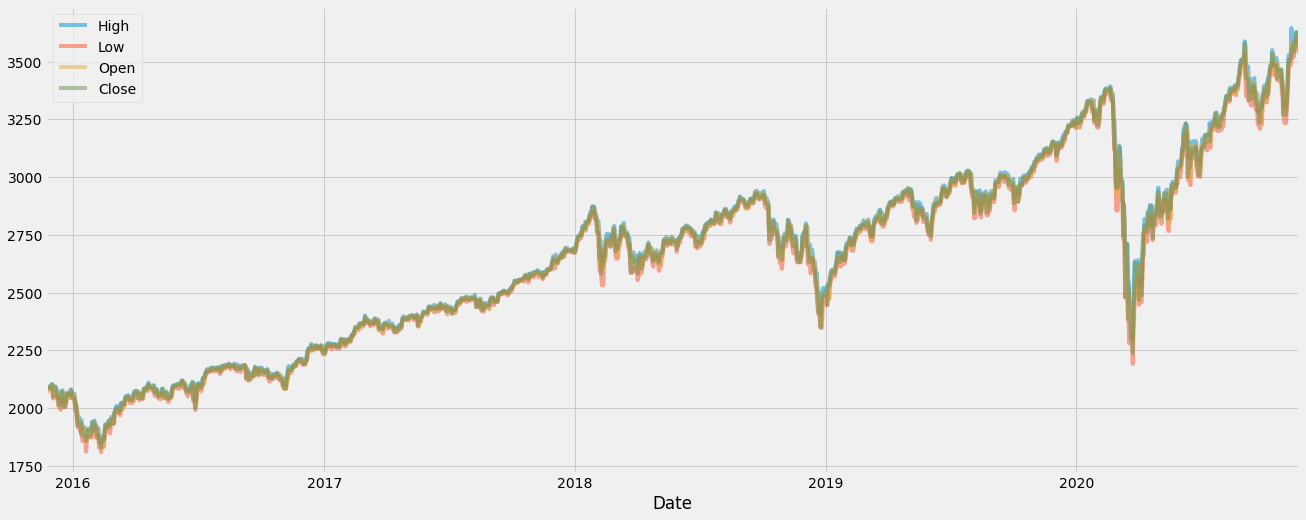

In [9]:
# Plotting the graph
df[['High','Low','Open','Close']].plot(figsize = (20, 8), alpha = 0.5)

## Observations from Plot

All four types of stock data have similar behaviour(follow the same pattern), so we can focus on only one( say 'High').
From the graph it is visible that the data is non-stationary, but here I will demonstrate by checking for characteristics as follows:

1. Variable variance
1. Variable mean
1. Seasonality
1. High Autocorrelation

And to top it all we finally do the famous **Dicky-Fuller Test**

## Checking for Non-Stationarity

### 1)  Non constant Mean and Variance

We can draw a histogram plot, if it shows uniform distribution, it implies that there exist a non-constant mean or "trend"

<AxesSubplot:>

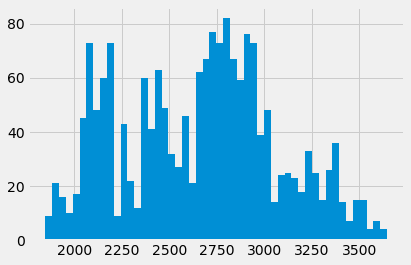

In [10]:
df.High.hist(bins=50)

We can neither say that this is uniform or non-uniform(for eg., normal). A better view can be given by statistical summary, for which we divide in chunks of 15 and calculate mean and standard deviation(which would account for variance) of each particular chunk.

In [11]:
np.round(df.shape[0]/15,0)

122.0

In [12]:
from statistics import stdev
mean=[]
std_dev=[]
    
for i in range(0,15):
    mean.append(df['High'].iloc[(i*122):(i*122)+122].mean())
    std_dev.append(stdev(df['High'].iloc[(i*122):(i*122)+122]))

pd.concat([pd.DataFrame(mean,columns=['Mean']),pd.DataFrame(std_dev,columns=['Std. Dev'])], axis=1)

,Mean,Std. Dev
0,1993.730425,73.388999
1,2092.346976,33.871675
2,2166.502221,21.518772
3,2299.840256,55.983300
4,2409.195240,36.844359
5,2519.581463,51.480562
6,2728.473199,66.613629
7,2728.200910,52.634535
8,2835.357200,76.381620
9,2693.783101,109.460731


We can clearly see variation of mean as uniform, that suffices for Non-constant mean (or trend). But for variance we cannot comment. Hence we can assume that the series is non-stationary for now and we can further move to prove this using seasonality and autocorrelation

### 2)  Seasonality

Seasonal decomposition is a function from statsmodels library which allows us to decompose the series into trend, seasonal and residual, either additive or multiplicative:

### Additive

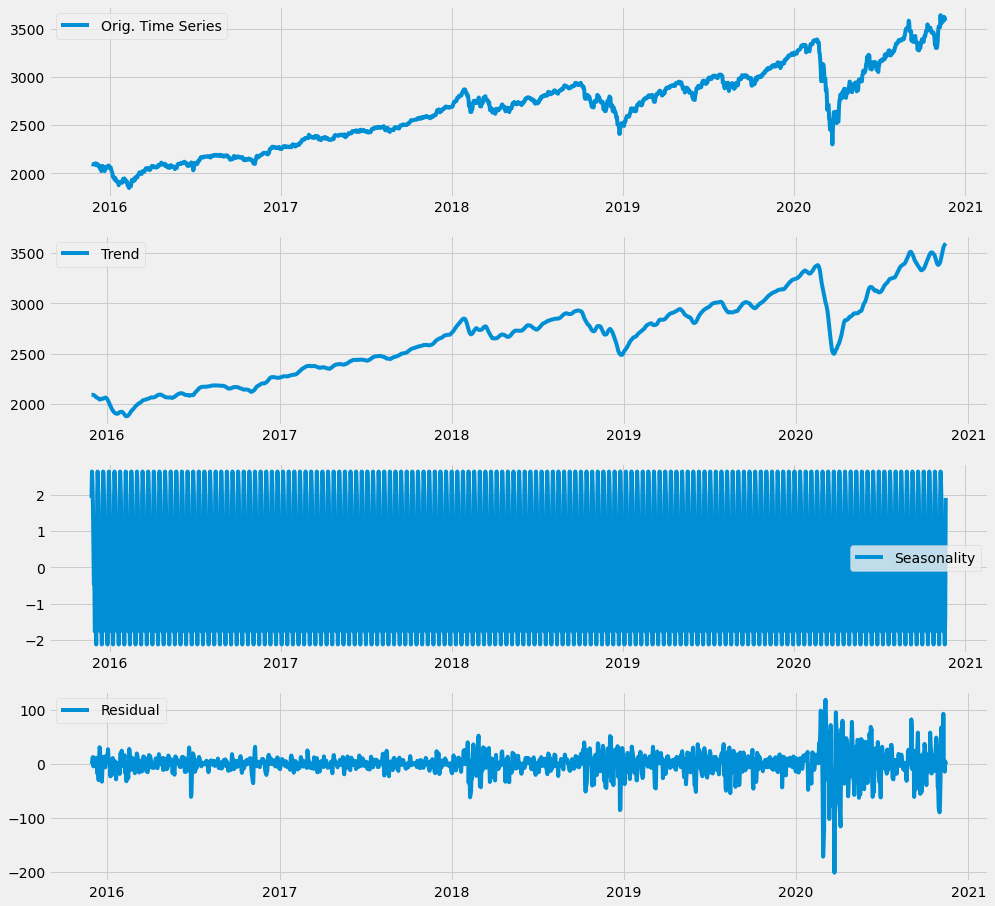

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_add=seasonal_decompose(df['High'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Orig. Time Series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

### Multiplicative

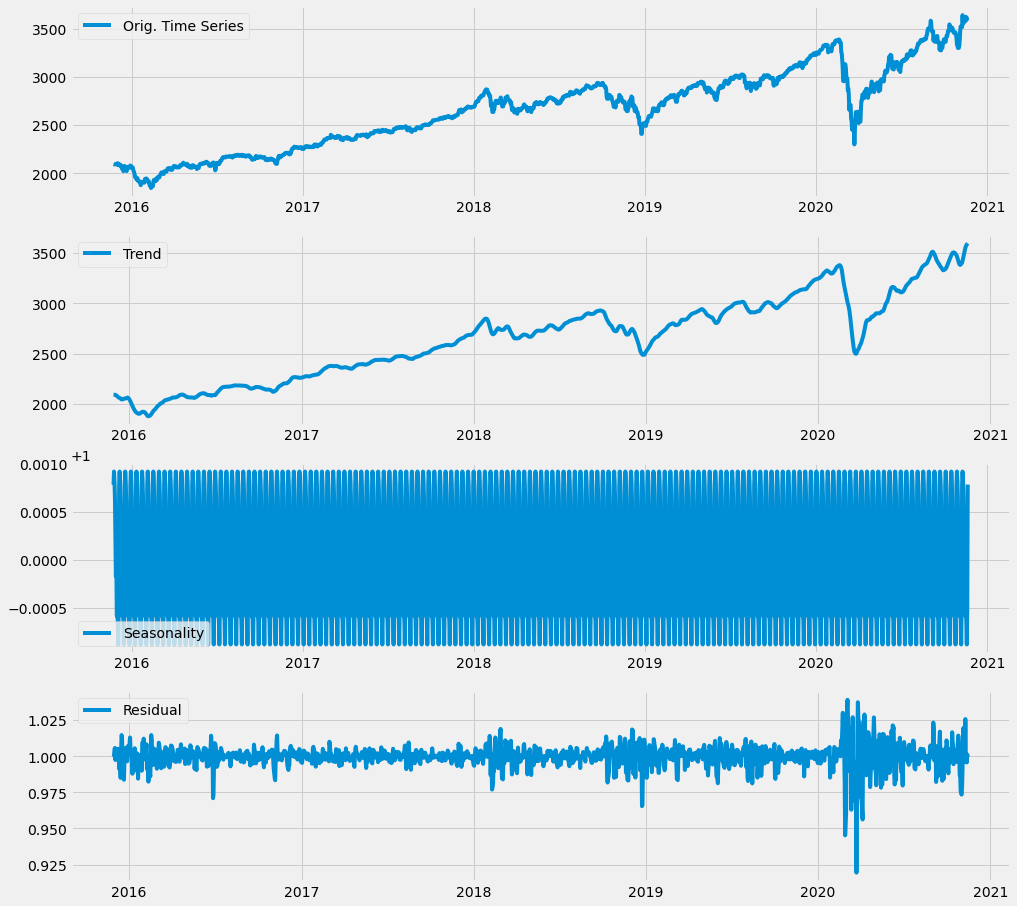

In [14]:
decompose_mul=seasonal_decompose(df['High'], model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Orig. Time Series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

Clearly a trend and a seasonal component can be observed. Also the decomposition seems to be additive

### 3) Autocorrelation

We import ACF and PACF from the statsmodels library to give us an insight into the Correlation factors

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

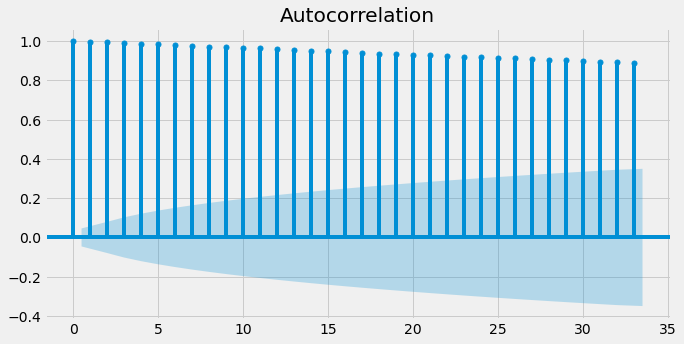

In [16]:
# AutoCorrelation

plt.rc("figure", figsize=(10,5))
plot_acf(df['High'])
print()

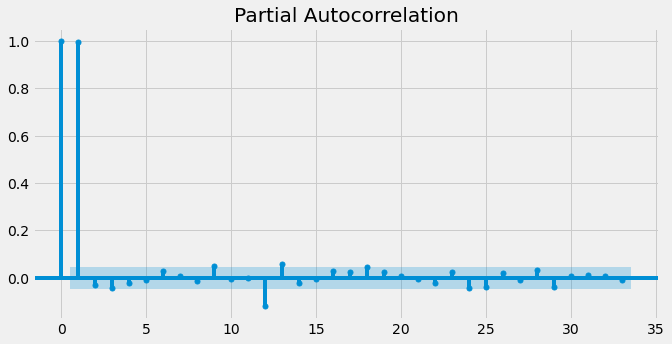

In [17]:
# Partial AutoCorrelation

plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
print()

Clearly high autocorrelation can be observed from the data!

### 4) Augmented Dicky-Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(log(df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.920468
p-value: 0.781157
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since p-value is greater than 0.5, the series is clearly a non-stationary type. Next we move on to applying models on the time series. For non-stationary data, a famous method would be using LSTM.

## Applying Models

We first apply a simple neural network with one layer as LSTM. For tuning hypermeters and changes in architecture, we do three comparisons as follows and calculate corresponding errors:

1) Changing window lengths

2) Increasing layers and epochs


After LSTM we also apply SimpleRNN to see which fits better to our data.

We will only study on 'High' data, Also train and validation split is 80:20

## 1) LSTM Model

In [19]:
new_df=df['High'].iloc[:-4]
train_len = math.ceil(len(new_df)*0.8)
window=15

train_data = new_df[0:train_len]

X_train=[]
Y_train=[]

# Appending chunk by chunk
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

# Necessary to convert into arrays
X_train, Y_train= np.array(X_train), np.array(Y_train)

# Reshaping the training set to (number of records-window, number of time steps, 1):
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1442, 15, 1)

In [20]:
X_train

array([[[2095.61010742],
        [2094.12011719],
        [2093.        ],
        ...,
        [2093.84008789],
        [2093.84008789],
        [2090.41992188]],

       [[2094.12011719],
        [2093.        ],
        [2093.        ],
        ...,
        [2093.84008789],
        [2090.41992188],
        [2073.85009766]],

       [[2093.        ],
        [2093.        ],
        [2093.29003906],
        ...,
        [2090.41992188],
        [2073.85009766],
        [2080.33007812]],

       ...,

       [[3066.94995117],
        [3066.94995117],
        [3066.94995117],
        ...,
        [3098.06005859],
        [3098.19995117],
        [3120.45996094]],

       [[3066.94995117],
        [3066.94995117],
        [3085.19995117],
        ...,
        [3098.19995117],
        [3120.45996094],
        [3120.45996094]],

       [[3066.94995117],
        [3085.19995117],
        [3083.94995117],
        ...,
        [3120.45996094],
        [3120.45996094],
        [3120.45996094]]

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# A LSTM layer and 2 dense layers
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=10, verbose=0)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


2021-10-15 07:08:01.200383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [22]:
# Using remaining for validation
val_data = new_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(val_data)):
    X_val.append(val_data[i-window:i])
    Y_val.append(val_data[i])

X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
X_val.shape, Y_val.shape

((364, 15, 1), (364,))

In [23]:
#Predictions
prediction = model.predict(X_val)
len(prediction), len(Y_val)

(364, 364)

To get a better view of where we are lets calculate error using RMSE

In [24]:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
print('Train RMSE Value:', np.sqrt(mean_squared_error(Y_train, train_pred)))
print('Validation RMSE Value:', np.sqrt(mean_squared_error(Y_val, val_pred)))

Train RMSE Value: 31.07757528777933
Validation RMSE Value: 109.16726573970303


We can clearly see that the values are high that implies high error, we next focus on improving the model by doing comparisons and learning on the go.

But before that lets plot and see how are predictions look like now!

In [25]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=val_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3125.805176
2019-11-20,3118.969971,3129.133057
2019-11-21,3110.110107,3132.877197
2019-11-22,3112.870117,3136.022461
2019-11-23,3112.870117,3136.133301
...,...,...
2020-11-12,3569.020020,3544.545898
2020-11-13,3593.659912,3307.838379
2020-11-14,3593.659912,3565.968018


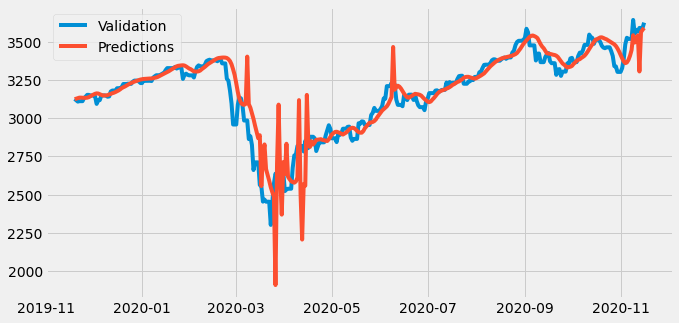

In [26]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Our Predictions seem to be shifted towards the right by a margin.

### Changing Window Length

In [27]:
train_error=[]
val_error=[]

window_array=[5,8,10,15,20,30,40]
for i in window_array:

    train_data = new_df[0:train_len]

    X_train=[]
    Y_train=[]

    for i in range(window, len(train_data)):
        X_train.append(train_data[i-window:i])
        Y_train.append(train_data[i])

    X_train, Y_train= np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
 
    val_data = new_df[train_len-window:]

    X_val=[]
    Y_val=[] 

    for i in range(window, len(val_data)):
        X_val.append(val_data[i-window:i])
        Y_val.append(val_data[i])

    X_val, Y_val = np.array(X_val), np.array(Y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    
    
    model=Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=20, batch_size=10, verbose=0)
 
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_error.append(np.sqrt(mean_squared_error(Y_train, train_pred)))
    val_error.append(np.sqrt(mean_squared_error(Y_val, val_pred)))

In [28]:
pd.concat([pd.DataFrame(train_error,columns=['train_error']),
           pd.DataFrame(val_error,columns=['val_error']),
           pd.DataFrame([5,8,10,15,20,30,40],columns=['window'])], axis=1).set_index('window')

,train_error,val_error
window,,
5,37.533054,95.322513
8,30.615377,116.193371
10,37.394700,113.209650
15,37.886730,102.449852
20,35.412211,94.924057
30,39.886852,102.917828
40,28.287414,82.653460


Doesn't change the RMSE value much. Next we try increasing epochs and neurons.

But the best window size with the least validation error, i.e, 8

### Increasing number of neurons and epochs

In [29]:
# Take best window from last check
window=8

train_data = new_df[0:train_len]
X_train=[]
Y_train=[]
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

val_data = new_df[train_len-window:]
X_val=[]
Y_val=[] 
for i in range(window, len(val_data)):
    X_val.append(val_data[i-window:i])
    Y_val.append(val_data[i])
    
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [30]:
# Increase a LSTM layer and a hidden layer.

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 50)             10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_17 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 26        
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In [31]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, val_pred)))

Train rmse: 22.24538034810817
Validation rmse: 59.9783044495752


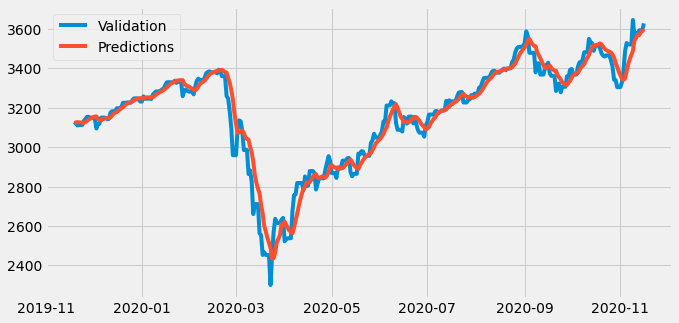

In [32]:
# Plotting the new graph
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=val_pred
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Better than before (less right skewed), but still the RMSE values are high

## 2) SimpleRNN Model

2 layers of Simple RNN and 3 Dense layers.

In [33]:
from keras.layers import SimpleRNN

model=Sequential()
model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)


In [34]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, val_pred)))

Train rmse: 21.70214668420085
Validation rmse: 43.114183105302864


In [35]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=val_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3104.227051
2019-11-20,3118.969971,3107.751953
2019-11-21,3110.110107,3099.038086
2019-11-22,3112.870117,3089.746094
2019-11-23,3112.870117,3092.869141
...,...,...
2020-11-12,3569.020020,3560.357910
2020-11-13,3593.659912,3541.181152
2020-11-14,3593.659912,3571.199463


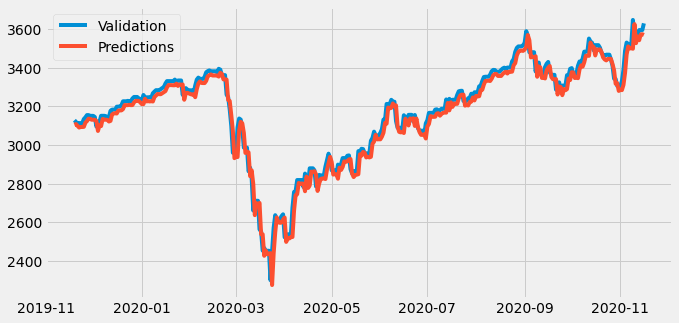

In [36]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

We can clearly see from RMSE and the plot, that SimpleRNN perform much much better than LSTM

# Prediction

Below plot shows how our Model predicted stocks from 19/11/2019 to 16/11/2020. In this case only SimpleRNN is used, since it fits well

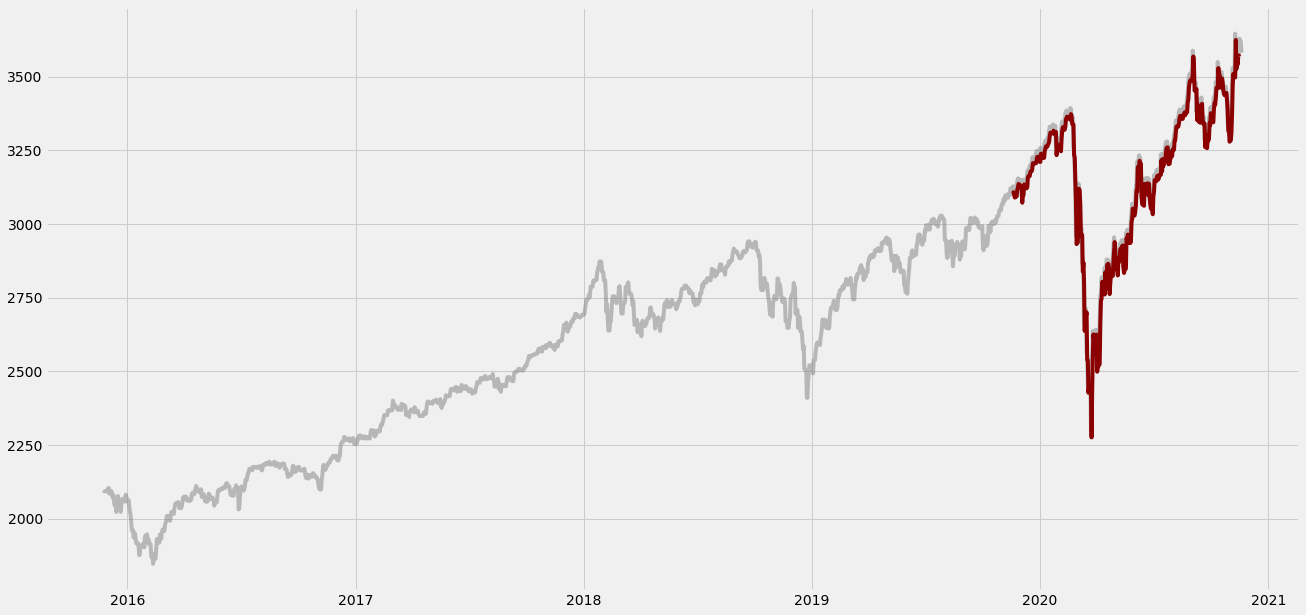

In [37]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(df['High'],c='grey',
         alpha=0.5,label='Original Data')
plt.plot(valid['Predictions'],label='Testing Forecast', c='darkred')
plt.show()